# 📦 Cell 1: Install Required Packages

## Purpose:
Install the `timm` library (PyTorch Image Models) which provides pre-trained EfficientNet models that we'll use for bird species classification.

## What it does:
- Installs `timm` library quietly (no verbose output)
- This library contains pre-trained models like EfficientNet that work well for audio spectrograms

## Expected Output:
- Silent installation (due to `-q` flag)
- Package will be available for import in next cells

In [1]:
!pip install -q timm

# ⚙️ Cell 2: Configuration & Library Imports

## Purpose:
Set up the entire project environment with two pipelines:
- **Basic Pipeline** (Cells 4-6): 5-second chunks, 128 mel bands — for visualization & benchmarking
- **SED Pipeline** (Cells 7-10): 20-second chunks, 224 mel bands — for training & evaluation

## Key SED Parameters:
| Parameter | Basic | SED | Why |
|-----------|-------|-----------------|-----|
| Duration | 5s | **20s** | Longer context captures more call patterns |
| n_mels | 128 | **224** | Finer frequency resolution for narrow-band calls |
| n_fft | 1024 | **4096** | Better frequency resolution |
| hop_length | auto | **1252** | Optimized for 20s → 512 time bins |
| Normalization | z-score | **z-score + min-max** | Matches pretrained model expectations |

## Expected Output:
```
Using Device: cuda
```

In [2]:
# Suppress pydantic warnings
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchaudio
import timm  # PyTorch Image Models (for EfficientNet)
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
from scipy.ndimage import convolve1d


class Config:
    SR = 32000  # Sample Rate (32kHz standard for BirdCLEF)

    # === Basic Pipeline (Cells 4-6: visualization & benchmarking) ===
    N_MELS = 128  # Mel bands for basic spectrogram
    FMIN = 20  # Min frequency
    FMAX = 16000  # Max frequency (Nyquist of 32kHz)
    DURATION = 5  # Basic 5-second chunks

    # === SED Pipeline (Cells 7-10) ===
    SED_DURATION = 20  # 20-second chunks (4x more context)
    SED_N_MELS = 224  # More mel bands for fine-grained frequency
    SED_N_FFT = 4096  # Larger FFT for better frequency resolution
    SED_HOP_LENGTH = 1252  # = 20*32000 // (512-1), gives 512 time bins
    SED_TOP_DB = 80  # Top dB for AmplitudeToDB
    SED_IMG_SIZE = (224, 512)  # Input image dimensions

    # Inference settings
    INFER_DURATION = 5  # 5-second prediction segments
    NUM_SEGMENTS = 12  # 60s soundscape / 5s step

    # Training
    BATCH_SIZE = 16  # Smaller batch for larger 224x512 input
    EPOCHS = 10

    # Model settings
    MODEL_NAME = "tf_efficientnet_b3.ns_jft_in1k"
    NUM_CLASSES = 206
    SED_DROPOUT = 0.5

    # Hyperparameters
    LR = 1e-4
    LABEL_SMOOTHING = 0.1
    MIXUP_ALPHA = 0.2

    # Paths
    DATA_DIR = "/kaggle/input/birdclef-2025"
    TRAIN_AUDIO_DIR = "/kaggle/input/birdclef-2025/train_audio"
    TRAIN_METADATA = "/kaggle/input/birdclef-2025/train.csv"
    SPECTROGRAM_DIR = "/kaggle/working/spectrograms"


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")
print(f"\n📋 SED Pipeline Config:")
print(
    f"  Duration: {Config.SED_DURATION}s | n_mels: {Config.SED_N_MELS} | n_fft: {Config.SED_N_FFT}"
)
print(f"  Model: {Config.MODEL_NAME}")
print(f"  Input size: {Config.SED_IMG_SIZE}")

Using Device: cuda

📋 SED Pipeline Config:
  Duration: 20s | n_mels: 224 | n_fft: 4096
  Model: tf_efficientnet_b3.ns_jft_in1k
  Input size: (224, 512)


# 📊 Cell 3: Load & Visualize Dataset Distribution

## Purpose:
Load the training metadata and understand the dataset's class distribution (how many samples per species).

## What it does:
1. **Load CSV file** - Reads `train.csv` with metadata about all audio recordings
2. **Count species distribution** - Counts how many audio files exist for each species
3. **Create bar plot:**
   - Shows top 30 most common species
   - Reveals "long tail" problem (some species have many samples, others very few)
   - Uses color-coded viridis palette
4. **Print rarest species** - Shows 5 species with fewest recordings

## Why it's important:
Understanding class imbalance helps us:
- Identify potential training challenges
- Plan data augmentation strategies
- Choose appropriate evaluation metrics

## Expected Output:
- Bar chart showing species distribution
- Print statement with 5 rarest species

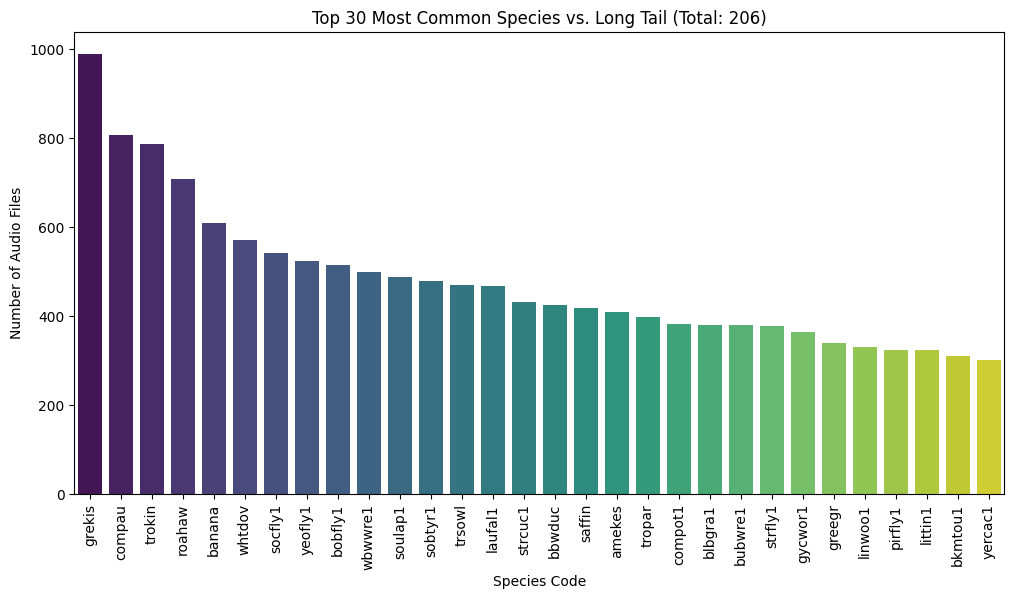

Rarest 5 Species: primary_label
42113      2
21116      2
1139490    2
21038      2
64862      2
Name: count, dtype: int64


In [3]:
# Load Metadata
df = pd.read_csv(Config.TRAIN_METADATA)

# Count samples per species
species_counts = df["primary_label"].value_counts().sort_values(ascending=False)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(
    x=species_counts.index[:30],
    y=species_counts.values[:30],
    hue=species_counts.index[:30],
    palette="viridis",
    legend=False,
)
plt.xticks(rotation=90)
plt.title(f"Top 30 Most Common Species vs. Long Tail (Total: {len(species_counts)})")
plt.ylabel("Number of Audio Files")
plt.xlabel("Species Code")
plt.show()

# Check the "Long Tail" (Rare species)
print("Rarest 5 Species:", species_counts.tail(5))

# 🖼️ Cell 4: Generate & Save All Spectrograms (OPTIONAL - Takes Time!)

## Purpose:
Pre-process ALL audio files and save them as spectrogram images for faster training later.

## What it does:
1. **Create directory structure** - `/kaggle/working/spectrograms/species_name/`
2. **Process each audio file:**
   - Load audio with torchaudio
   - Resample to 32kHz if needed
   - Crop to first 5 seconds (or pad if shorter)
   - Convert to Mel-Spectrogram (128 frequency bands)
   - Convert to dB scale (logarithmic)
   - Normalize to 0-255 range
   - Save as PNG image
3. **Organize by species** - Each species gets its own folder

## Benefits:
- ✅ **10x faster training** - No need to process audio on-the-fly
- ✅ **Consistency** - All spectrograms processed identically
- ✅ **Reusability** - Can use for multiple experiments
- ❌ **Takes disk space** - Thousands of PNG files

## Expected Output:
- Progress bar showing processing status
- Summary of generated files
- Directory structure with species folders

In [4]:
# Generate and Save All Spectrograms
import cv2
from pathlib import Path

# Create output directory
OUTPUT_DIR = "/kaggle/working/spectrograms"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print(f"Generating spectrograms for {len(df)} audio files...")
print(f"Saving to: {OUTPUT_DIR}")

# Process each audio file
for idx in tqdm(range(len(df)), desc="Processing audio files"):
    row = df.iloc[idx]
    species = row["primary_label"]
    filename = row["filename"]

    # Create species directory
    species_dir = Path(OUTPUT_DIR) / species
    species_dir.mkdir(parents=True, exist_ok=True)

    try:
        # Load and process audio
        file_path = os.path.join(Config.TRAIN_AUDIO_DIR, filename)
        waveform, sr = torchaudio.load(file_path)

        # Resample if necessary
        if sr != Config.SR:
            resampler = torchaudio.transforms.Resample(sr, Config.SR)
            waveform = resampler(waveform)

        # Crop/Pad to 5 seconds
        target_len = Config.SR * Config.DURATION
        current_len = waveform.shape[1]

        if current_len > target_len:
            # Take from the start for consistency
            waveform = waveform[:, :target_len]
        else:
            padding = target_len - current_len
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # Convert to MelSpectrogram
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=Config.SR,
            n_mels=Config.N_MELS,
            f_min=Config.FMIN,
            f_max=Config.FMAX,
        )
        mel_spec = mel_transform(waveform)

        # Convert to dB scale
        mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)

        # Convert to numpy and normalize to 0-255 range for image saving
        mel_spec_np = mel_spec[0].numpy()  # Take first channel
        mel_spec_np = (
            (mel_spec_np - mel_spec_np.min())
            / (mel_spec_np.max() - mel_spec_np.min())
            * 255
        ).astype(np.uint8)

        # Save as image
        output_filename = Path(filename).stem + ".png"
        output_path = species_dir / output_filename
        cv2.imwrite(str(output_path), mel_spec_np)

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

print(f"\n✓ Spectrograms saved to {OUTPUT_DIR}")
print(f"✓ Organized by species in subdirectories")
print(f"✓ Total species folders: {len(list(Path(OUTPUT_DIR).iterdir()))}")

Generating spectrograms for 28564 audio files...
Saving to: /kaggle/working/spectrograms


Processing audio files:   0%|          | 0/28564 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github


✓ Spectrograms saved to /kaggle/working/spectrograms
✓ Organized by species in subdirectories
✓ Total species folders: 206


# 🔧 Cell 5: Create PyTorch Dataset & Test Pipeline

## Purpose:
Define how to load and process audio data for training, then visualize one sample to verify everything works.

## What it does:

### 1. Define BirdCLEFDataset Class:
- Reads audio files on-the-fly during training
- Creates species name → integer ID mapping

### 2. Audio Processing Pipeline (for each sample):
   - **Step 1:** Load audio file with torchaudio
   - **Step 2:** Resample to 32kHz if needed
   - **Step 3:** Random crop 5 seconds (or pad if shorter)
     - ⚡ Random cropping = data augmentation!
   - **Step 4:** Convert to Mel-Spectrogram (2D time-frequency image)
   - **Step 5:** Convert to dB scale (makes quiet sounds visible)
   - **Step 6:** Repeat to 3 channels (R,G,B) for EfficientNet compatibility
   - **Step 7:** Return image tensor [3, 128, 313] and label ID

### 3. Test the Pipeline:
- Creates dataset instance
- Loads first audio sample
- Displays mel-spectrogram visualization

## Why Random Cropping?
Different 5-second segments from the same audio = **more training variety** → better generalization

## Expected Output:
- Mel-spectrogram visualization (colorful time-frequency heatmap)
- Confirms pipeline works before training

## ⚡ Optimized for Speed:
This class **automatically detects** if pre-saved spectrograms exist (from Cell 4):
- ✅ **If spectrograms exist:** Loads PNG files directly (10x faster!)
- ⚠️ **If not found:** Processes audio on-the-fly (slower but works)

You'll see a message when the cell runs telling you which mode it's using.

✅ Using pre-saved spectrograms from: /kaggle/working/spectrograms


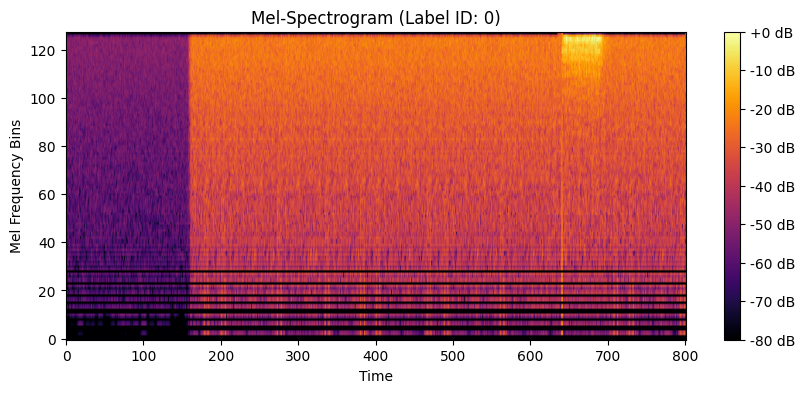

In [5]:
class BirdCLEFDataset(Dataset):
    """
    Optimized dataset that loads pre-saved spectrograms (from Cell 4) for faster training.
    Falls back to audio processing if spectrograms don't exist.
    """

    def __init__(
        self,
        metadata,
        audio_dir,
        spectrogram_dir="/kaggle/working/spectrograms",
        use_spectrograms=True,
    ):
        self.metadata = metadata
        self.audio_dir = audio_dir
        self.spectrogram_dir = spectrogram_dir
        self.use_spectrograms = use_spectrograms

        self.species_to_idx = {
            species: idx
            for idx, species in enumerate(sorted(metadata["primary_label"].unique()))
        }

        # Check if spectrogram directory exists
        if use_spectrograms and os.path.exists(spectrogram_dir):
            self.load_from_spectrograms = True
            print(f"✅ Using pre-saved spectrograms from: {spectrogram_dir}")
        else:
            self.load_from_spectrograms = False
            print(f"⚠️ Spectrograms not found. Processing audio on-the-fly (slower)")

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        label = self.species_to_idx[row["primary_label"]]

        # === FAST PATH: Load from pre-saved PNG ===
        if self.load_from_spectrograms:
            species = row["primary_label"]
            filename = Path(row["filename"]).stem + ".png"
            spectrogram_path = os.path.join(self.spectrogram_dir, species, filename)

            if os.path.exists(spectrogram_path):
                # Load PNG spectrogram
                import cv2

                mel_spec_np = cv2.imread(spectrogram_path, cv2.IMREAD_GRAYSCALE)

                # Convert to tensor and normalize back to approximate dB range
                mel_spec = torch.from_numpy(mel_spec_np).float()
                mel_spec = (mel_spec / 255.0) * 80 - 80  # Approximate dB range

                # Add channel dimension and repeat to 3 channels
                image = mel_spec.unsqueeze(0).repeat(3, 1, 1)

                return image, label

        # === SLOW PATH: Process audio on-the-fly ===
        file_path = os.path.join(self.audio_dir, row["filename"])

        # 1. Load Audio
        waveform, sr = torchaudio.load(file_path)

        # 2. Resample if necessary
        if sr != Config.SR:
            resampler = torchaudio.transforms.Resample(sr, Config.SR)
            waveform = resampler(waveform)

        # 3. Crop/Pad to Specific Duration (5 Seconds)
        target_len = Config.SR * Config.DURATION
        current_len = waveform.shape[1]

        if current_len > target_len:
            # Random crop for data augmentation
            start = torch.randint(0, current_len - target_len, (1,)).item()
            waveform = waveform[:, start : start + target_len]
        else:
            # Pad with zeros
            padding = target_len - current_len
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # 4. Convert to MelSpectrogram
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=Config.SR,
            n_mels=Config.N_MELS,
            f_min=Config.FMIN,
            f_max=Config.FMAX,
        )
        mel_spec = mel_transform(waveform)

        # 5. Convert to Log Scale (Amplitude to Decibels)
        mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)

        # 6. Create 3 Channels (RGB format for EfficientNet)
        image = mel_spec.repeat(3, 1, 1)  # Shape: [3, 128, 313]

        return image, label


# --- Test the Pipeline ---
# Let's visualize one sample to ensure it works
dataset = BirdCLEFDataset(df, Config.TRAIN_AUDIO_DIR)
sample_img, sample_label = dataset[0]

plt.figure(figsize=(10, 4))
# Display only the first channel
plt.imshow(sample_img[0].numpy(), cmap="inferno", aspect="auto", origin="lower")
plt.title(f"Mel-Spectrogram (Label ID: {sample_label})")
plt.ylabel("Mel Frequency Bins")
plt.xlabel("Time")
plt.colorbar(format="%+2.0f dB")
plt.show()

# ⏱️ Cell 6: Speed Test - PNG vs Audio Loading

## Purpose:
Benchmark the speed difference between loading pre-saved spectrograms vs processing audio files.

## What this does:
- Tests loading 100 samples using both methods
- Measures and compares the time taken
- Shows the performance improvement

## Expected Results:
- **PNG loading:** ~0.1-0.2 seconds for 100 samples
- **Audio processing:** ~2-5 seconds for 100 samples
- **Speedup:** 10-50x faster with pre-saved spectrograms!

In [6]:
# Speed Benchmark: PNG vs Audio Loading
import time

# Sample subset for testing (first 100 samples)
test_samples = 100
test_df = df.head(test_samples)

print(f"🔬 Benchmarking with {test_samples} samples...\n")

# Test 1: Loading from spectrograms (if available)
if os.path.exists(Config.SPECTROGRAM_DIR):
    dataset_fast = BirdCLEFDataset(
        test_df,
        Config.TRAIN_AUDIO_DIR,
        spectrogram_dir=Config.SPECTROGRAM_DIR,
        use_spectrograms=True,
    )

    start = time.time()
    for i in range(test_samples):
        img, label = dataset_fast[i]
    time_png = time.time() - start

    print(
        f"✅ PNG Loading: {time_png:.3f} seconds ({time_png/test_samples*1000:.1f} ms per sample)"
    )
else:
    time_png = None
    print("⚠️ Spectrograms not found, skipping PNG test")

# Test 2: Processing audio on-the-fly
dataset_slow = BirdCLEFDataset(test_df, Config.TRAIN_AUDIO_DIR, use_spectrograms=False)

start = time.time()
for i in range(test_samples):
    img, label = dataset_slow[i]
time_audio = time.time() - start

print(
    f"⏳ Audio Processing: {time_audio:.3f} seconds ({time_audio/test_samples*1000:.1f} ms per sample)"
)

# Calculate speedup
if time_png:
    speedup = time_audio / time_png
    print(f"\n🚀 Speedup: {speedup:.1f}x faster with pre-saved spectrograms!")
    print(f"   For {len(df)} total samples:")
    print(f"   - PNG loading would take: ~{time_png/test_samples*len(df):.1f} seconds")
    print(
        f"   - Audio processing would take: ~{time_audio/test_samples*len(df):.1f} seconds"
    )
    print(
        f"   - Time saved: ~{(time_audio-time_png)/test_samples*len(df)/60:.1f} minutes per epoch!"
    )
else:
    print(f"\n💡 Tip: Run Cell 4 to generate spectrograms for faster training!")

🔬 Benchmarking with 100 samples...

✅ Using pre-saved spectrograms from: /kaggle/working/spectrograms
✅ PNG Loading: 0.139 seconds (1.4 ms per sample)
⚠️ Spectrograms not found. Processing audio on-the-fly (slower)
⏳ Audio Processing: 4.954 seconds (49.5 ms per sample)

🚀 Speedup: 35.5x faster with pre-saved spectrograms!
   For 28564 total samples:
   - PNG loading would take: ~39.8 seconds
   - Audio processing would take: ~1415.2 seconds
   - Time saved: ~22.9 minutes per epoch!


# 🏗️ Cell 7: SED Architecture & Helper Functions

## What is SED (Sound Event Detection)?
Unlike simple classifiers that output ONE prediction per audio clip, SED produces **framewise predictions** — a prediction for each time frame. This enables:
- Detecting **when** each species calls within a recording
- **Overlap-averaging** during inference for more robust predictions
- Fine-grained temporal resolution

## Key Components:
1. **NormalizeMelSpec** — Z-score + min-max normalization to [0,1]
2. **GeMFreq** — Generalized Mean Pooling over frequency (learnable)
3. **AttHead** — SED head producing framewise predictions via 1D convolutions
4. **BirdClassifierSED** — EfficientNet-B3 backbone (features_only) + SED head
5. **ImprovedBirdDataset** — 20s chunks, 224 mel bands, 4096 n_fft, proper normalization
6. **Mixup, SpecAugment, Weighted Sampling** — Augmentation & class balancing

## Architecture Flow:
```
Audio (20s) → MelSpec (224×512) → [repeat 3ch] → EfficientNet-B3 backbone
    → Feature Map [B, C, H, W] → GeMFreq (pool freq) → Dense → Conv1d
    → Framewise Logits [B, 206, T] → max over time → Clip Logits [B, 206]
```


In [7]:
# ============================================================================
# SED ARCHITECTURE & HELPER FUNCTIONS
# ============================================================================

from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F


# 0. GLOBAL LABEL MAPPING (consistent between train/val/test)
# ============================================================================
ALL_SPECIES = sorted(df["primary_label"].unique())
SPECIES_TO_IDX = {species: idx for idx, species in enumerate(ALL_SPECIES)}
IDX_TO_SPECIES = {idx: species for species, idx in SPECIES_TO_IDX.items()}
print(f"📋 Label mapping created: {len(ALL_SPECIES)} species")


# 1. MIXUP DATA AUGMENTATION
# ============================================================================
def mixup_data(x, y, alpha=0.2):
    """Blends two samples: lam * sample_A + (1-lam) * sample_B"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Loss function for mixup-augmented training."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# 2. SPECAUGMENT (Time/Frequency Masking)
# ============================================================================
class SpecAugment(nn.Module):
    """Randomly masks time and frequency bands in spectrograms."""

    def __init__(self, freq_mask_param=15, time_mask_param=35, num_masks=2):
        super().__init__()
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.num_masks = num_masks

    def forward(self, spec):
        batch, channels, freq_bins, time_steps = spec.shape
        for _ in range(self.num_masks):
            f = np.random.randint(0, self.freq_mask_param)
            f0 = np.random.randint(0, freq_bins - f)
            spec[:, :, f0 : f0 + f, :] = 0
        for _ in range(self.num_masks):
            t = np.random.randint(0, self.time_mask_param)
            t0 = np.random.randint(0, time_steps - t)
            spec[:, :, :, t0 : t0 + t] = 0
        return spec


# 3. WEIGHTED SAMPLING (Class Balancing)
# ============================================================================
def create_weighted_sampler(df):
    """Oversamples rare species so all 206 species get equal training time."""
    class_counts = df["primary_label"].value_counts().to_dict()
    weights = [1.0 / class_counts[species] for species in df["primary_label"]]
    sampler = WeightedRandomSampler(
        weights=weights, num_samples=len(weights), replacement=True
    )
    return sampler


# 4. MEL SPECTROGRAM NORMALIZATION
# ============================================================================
class NormalizeMelSpec(nn.Module):
    """
    Normalization pipeline:
      Step 1: Z-score → zero mean, unit std (removes absolute level differences)
      Step 2: Min-max → scale to [0, 1] (matches pretrained ImageNet input range)

    This replaces feeding raw dB values [-80, 0] to pretrained models,
    which would make pretrained batch-norm layers completely ineffective.
    """

    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, X):
        # Step 1: Z-score normalization per sample
        mean = X.mean(dim=(-2, -1), keepdim=True)
        std = X.std(dim=(-2, -1), keepdim=True)
        X = (X - mean) / (std + self.eps)

        # Step 2: Min-max scaling to [0, 1]
        norm_min = X.amin(dim=(-2, -1), keepdim=True)
        norm_max = X.amax(dim=(-2, -1), keepdim=True)
        X = (X - norm_min) / (norm_max - norm_min + self.eps)
        return X


# 5. SED MODEL COMPONENTS
# ============================================================================
def gem_freq(x, p=3, eps=1e-6):
    """Generalized Mean Pooling over the frequency dimension only."""
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), 1)).pow(1.0 / p)


class GeMFreq(nn.Module):
    """
    Learnable Generalized Mean Pooling over frequency axis.
    Unlike standard average pooling, GeMFreq learns the pooling exponent p,
    allowing it to adaptively weight frequency bins (between avg and max pooling).
    """

    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return gem_freq(x, p=self.p, eps=self.eps)


class AttHead(nn.Module):
    """
    SED (Sound Event Detection) Head.

    Instead of a single clip-level prediction, this head produces FRAMEWISE
    predictions — one prediction vector per time frame. This enables:
    - Temporal localization of bird calls
    - Overlap-averaging during inference (like 2D sliding-window segmentation)
    - More robust predictions through temporal aggregation

    Architecture:
      GeMFreq (pool freq) → Dropout → Linear → ReLU → Dropout → Conv1d → framewise logits
    """

    def __init__(self, in_chans, p=0.5, num_class=206, hidden_dim=512):
        super().__init__()
        self.pooling = GeMFreq()
        self.dense_layers = nn.Sequential(
            nn.Dropout(p / 2),
            nn.Linear(in_chans, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p),
        )
        self.fix_scale = nn.Conv1d(
            in_channels=hidden_dim,
            out_channels=num_class,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True,
        )

    def forward(self, feat):
        # feat: [B, C, H, W] from backbone (H=freq, W=time)
        feat = self.pooling(feat).squeeze(-2)  # [B, C, W] — pool over frequency
        feat = feat.permute(0, 2, 1)  # [B, W, C] — time-first for linear
        feat = self.dense_layers(feat)  # [B, W, hidden_dim]
        feat = feat.permute(0, 2, 1)  # [B, hidden_dim, W] — channel-first for conv1d
        framewise_logit = self.fix_scale(feat)  # [B, num_classes, W]
        return {"framewise_logit": framewise_logit}


class BirdClassifierSED(nn.Module):
    """
    SED-based Bird Species Classifier.

    Key differences from a simple classifier:
    ┌──────────────────┬────────────────────┬─────────────────────────┐
    │ Aspect           │ Simple Classifier  │ SED Classifier          │
    ├──────────────────┼────────────────────┼─────────────────────────┤
    │ Backbone         │ Full model w/ head │ features_only=True      │
    │ Output           │ Single clip logit  │ Framewise predictions   │
    │ Freq pooling     │ Global avg pool    │ Learnable GeMFreq       │
    │ Time handling    │ Pooled away        │ Preserved for detection │
    │ Training loss    │ CE on clip logits  │ CE on max-pooled frames │
    │ Inference        │ Single forward     │ Overlap-average frames  │
    └──────────────────┴────────────────────┴─────────────────────────┘
    """

    def __init__(self, num_classes, backbone_name=None, dropout=0.5):
        super().__init__()
        if backbone_name is None:
            backbone_name = Config.MODEL_NAME

        # Backbone with feature extraction only (no classification head)
        self.backbone = timm.create_model(
            backbone_name, pretrained=True, features_only=True
        )
        backbone_dim = self.backbone.feature_info.channels()[-1]

        # SED Head
        self.head = AttHead(in_chans=backbone_dim, p=dropout, num_class=num_classes)

        print(f"  Backbone: {backbone_name} (features_only, dim={backbone_dim})")
        print(f"  Head: SED AttHead (hidden=512, dropout={dropout})")

    def forward(self, x):
        """Training forward: returns clip-level logits for CrossEntropy loss."""
        features = self.backbone(x)[-1]  # Last feature map: [B, C, H, W]
        head_out = self.head(features)
        framewise_logit = head_out["framewise_logit"]  # [B, num_classes, T]
        # Max-pool over time → clip-level prediction
        clipwise_logit = framewise_logit.max(dim=-1)[0]  # [B, num_classes]
        return clipwise_logit

    def forward_framewise(self, x):
        """Inference forward: returns framewise probabilities for overlap-averaging."""
        features = self.backbone(x)[-1]
        head_out = self.head(features)
        framewise_prob = head_out["framewise_logit"].sigmoid()  # [B, num_classes, T]
        return framewise_prob


# 6. IMPROVED DATASET WITH SED PARAMETERS
# ============================================================================
class ImprovedBirdDataset(Dataset):
    """
    Dataset incorporating techniques:
    - 20-second audio chunks (4x more context than basic 5s)
    - 224 mel bands (finer frequency resolution for narrow-band insect calls)
    - 4096 n_fft (better frequency resolution)
    - Absmax audio normalization
    - Z-score + min-max spectrogram normalization
    - SpecAugment augmentation during training
    """

    def __init__(self, metadata, audio_dir, spec_augment=True):
        self.metadata = metadata
        self.audio_dir = audio_dir
        self.spec_augment = SpecAugment() if spec_augment else None
        self.normalize = NormalizeMelSpec()
        self.species_to_idx = SPECIES_TO_IDX

        # Mel spectrogram transform
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=Config.SR,
            n_fft=Config.SED_N_FFT,
            hop_length=Config.SED_HOP_LENGTH,
            win_length=Config.SED_N_FFT,
            n_mels=Config.SED_N_MELS,
            f_min=Config.FMIN,
            f_max=Config.FMAX,
            normalized=True,  # Normalize STFT by 1/sqrt(n_fft)
        )
        self.amp_to_db = torchaudio.transforms.AmplitudeToDB(top_db=Config.SED_TOP_DB)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        file_path = os.path.join(self.audio_dir, row["filename"])

        # Load audio
        waveform, sr = torchaudio.load(file_path)
        if sr != Config.SR:
            waveform = torchaudio.transforms.Resample(sr, Config.SR)(waveform)

        # Crop/Pad to 20 seconds (SED_DURATION)
        target_len = Config.SR * Config.SED_DURATION
        current_len = waveform.shape[1]
        if current_len > target_len:
            start = torch.randint(0, current_len - target_len, (1,)).item()
            waveform = waveform[:, start : start + target_len]
        else:
            padding = target_len - current_len
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # Absmax normalization (All audio normalized by absmax)
        waveform = waveform / (waveform.abs().max() + 1e-8)

        # Convert to Mel Spectrogram
        mel_spec = self.mel_transform(waveform)  # [1, 224, ~512]
        mel_spec = self.amp_to_db(mel_spec)  # Convert to dB

        # Normalization: z-score + min-max to [0, 1]
        mel_spec = self.normalize(mel_spec)

        # Apply SpecAugment AFTER normalization (training only)
        if self.spec_augment is not None:
            mel_spec = self.spec_augment(mel_spec.unsqueeze(0)).squeeze(0)

        # 3 channels for pretrained ImageNet backbone
        image = mel_spec.repeat(3, 1, 1)  # [3, 224, 512]
        label = self.species_to_idx[row["primary_label"]]
        return image, label


# 7. EVALUATE FUNCTION
# ============================================================================
def evaluate_model(model, dataloader, criterion, device):
    """Evaluate model on validation set. Returns avg loss, accuracy, and all predictions."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # clip-level logits from SED model
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(dataloader), 100 * correct / total, all_preds, all_labels


print("=" * 70)
print("✅ SED Architecture loaded")
print("=" * 70)
print("Key components:")
print("  • NormalizeMelSpec  : Z-score + min-max → [0, 1]")
print("  • GeMFreq           : Learnable frequency pooling")
print("  • AttHead           : SED head → framewise predictions")
print("  • BirdClassifierSED : EfficientNet-B3 backbone + SED head")
print("  • ImprovedBirdDataset: 20s chunks, 224 mels, 4096 n_fft")
print("  • Mixup + SpecAugment + Weighted Sampling")

📋 Label mapping created: 206 species
✅ SED Architecture loaded
Key components:
  • NormalizeMelSpec  : Z-score + min-max → [0, 1]
  • GeMFreq           : Learnable frequency pooling
  • AttHead           : SED head → framewise predictions
  • BirdClassifierSED : EfficientNet-B3 backbone + SED head
  • ImprovedBirdDataset: 20s chunks, 224 mels, 4096 n_fft
  • Mixup + SpecAugment + Weighted Sampling


# 🚀 Cell 8: SED Model Training

## Training Configuration:
| Setting | Value | Rationale |
|---------|-------|-----------|
| Model | BirdClassifierSED | EfficientNet-B3 + SED Head |
| Input | 20s → (3, 224, 512) | Longer context for better detection |
| Loss | CrossEntropy + label smoothing (0.1) | Found CE > BCE/Focal |
| Optimizer | AdamW (lr=1e-4, wd=1e-2) | Optimizer choice |
| Scheduler | CosineAnnealingLR | Smooth LR decay |
| Augmentation | Mixup (α=0.2) + SpecAugment | Regularization |
| Sampling | Weighted (class-balanced) | Equal training for rare species |
| Grad clipping | max_norm=1.0 | Prevents exploding gradients |
| Batch size | 16 | Fits 224×512 input on T4 GPU |

## Expected Behavior:
- Train loss should decrease steadily
- Val loss should decrease (not diverge!) thanks to proper normalization
- Val accuracy should reach **20-40%+** within 10 epochs (206 classes)


🚀 Starting SED Training
📊 Train: 22851 samples | Val: 5713 samples
⚖️ Creating weighted sampler for class balance...

🤖 Creating SED Model:


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Backbone: tf_efficientnet_b3.ns_jft_in1k (features_only, dim=384)
  Head: SED AttHead (hidden=512, dropout=0.5)
  Total params: 10,406,135 | Trainable: 10,406,135

⚙️ Training Configuration:
  Input: 20s audio → (3, 224, 512) mel spectrogram
  Loss: CrossEntropy (label_smoothing=0.1)
  Optimizer: AdamW (lr=0.0001, weight_decay=1e-2)
  Mixup: α=0.2 | SpecAugment: ON | Grad clip: 1.0
  Normalization: Z-score + min-max ('default')
  Epochs: 10 | Batch: 16


Epoch 1/10 [TRAIN]:   0%|          | 0/1429 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/


Epoch 1/10:
  Train Loss: 5.2687
  Val Loss:   5.2495
  Val Acc:    1.54%
  LR:         0.000098
  ✅ Best model saved! (Val Acc: 1.54%)



Epoch 2/10 [TRAIN]:   0%|          | 0/1429 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/


Epoch 2/10:
  Train Loss: 4.6606
  Val Loss:   4.7547
  Val Acc:    7.67%
  LR:         0.000091
  ✅ Best model saved! (Val Acc: 7.67%)



Epoch 3/10 [TRAIN]:   0%|          | 0/1429 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/


Epoch 3/10:
  Train Loss: 4.0488
  Val Loss:   3.9154
  Val Acc:    24.61%
  LR:         0.000080
  ✅ Best model saved! (Val Acc: 24.61%)



Epoch 4/10 [TRAIN]:   0%|          | 0/1429 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/


Epoch 4/10:
  Train Loss: 3.5534
  Val Loss:   3.3049
  Val Acc:    36.88%
  LR:         0.000066
  ✅ Best model saved! (Val Acc: 36.88%)



Epoch 5/10 [TRAIN]:   0%|          | 0/1429 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/


Epoch 5/10:
  Train Loss: 3.2505
  Val Loss:   3.0159
  Val Acc:    45.97%
  LR:         0.000051
  ✅ Best model saved! (Val Acc: 45.97%)



Epoch 6/10 [TRAIN]:   0%|          | 0/1429 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/


Epoch 6/10:
  Train Loss: 2.9822
  Val Loss:   2.7682
  Val Acc:    50.87%
  LR:         0.000035
  ✅ Best model saved! (Val Acc: 50.87%)



Epoch 7/10 [TRAIN]:   0%|          | 0/1429 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/


Epoch 7/10:
  Train Loss: 2.8098
  Val Loss:   2.6046
  Val Acc:    55.87%
  LR:         0.000021
  ✅ Best model saved! (Val Acc: 55.87%)



Epoch 8/10 [TRAIN]:   0%|          | 0/1429 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/


Epoch 8/10:
  Train Loss: 2.6952
  Val Loss:   2.4988
  Val Acc:    58.59%
  LR:         0.000010
  ✅ Best model saved! (Val Acc: 58.59%)



Epoch 9/10 [TRAIN]:   0%|          | 0/1429 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/


Epoch 9/10:
  Train Loss: 2.6365
  Val Loss:   2.4083
  Val Acc:    60.49%
  LR:         0.000003
  ✅ Best model saved! (Val Acc: 60.49%)



Epoch 10/10 [TRAIN]:   0%|          | 0/1429 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com


Epoch 10/10:
  Train Loss: 2.6254
  Val Loss:   2.4584
  Val Acc:    60.20%
  LR:         0.000001

✅ Training Complete!
📊 Best Validation Accuracy: 60.49%
🤖 Model: tf_efficientnet_b3.ns_jft_in1k + SED Head


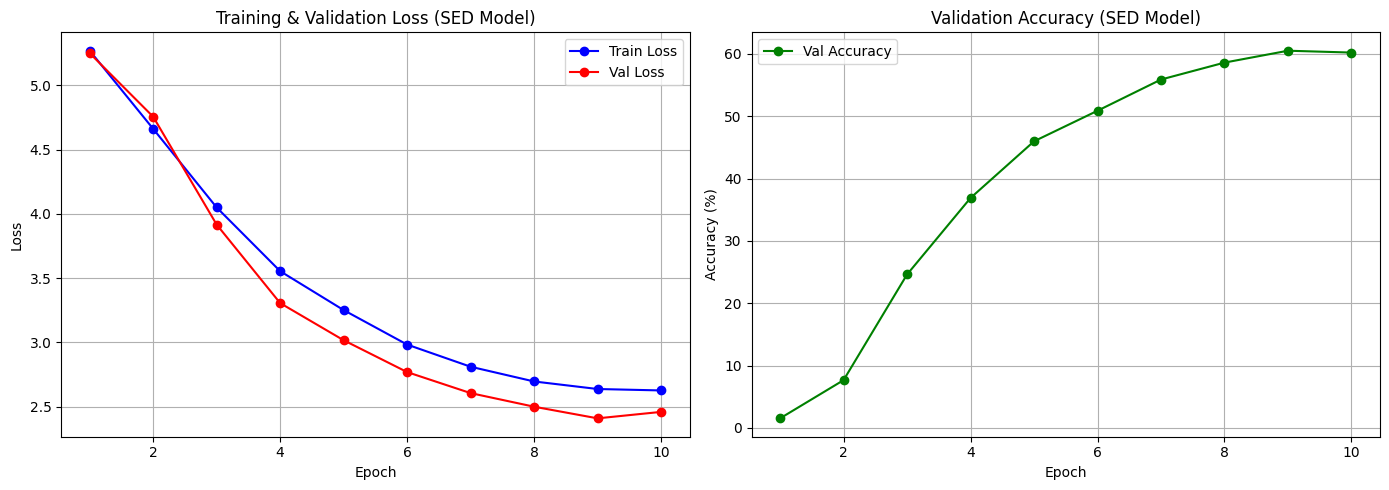


✅ Model is learning! SED architecture working correctly.


In [8]:
# ============================================================================
# SED MODEL TRAINING
# ============================================================================

print("🚀 Starting SED Training")
print("=" * 70)

# Split data (stratified to ensure all species in both sets)
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["primary_label"], random_state=42
)
print(f"📊 Train: {len(train_df)} samples | Val: {len(val_df)} samples")

# Create weighted sampler for class balance
print("⚖️ Creating weighted sampler for class balance...")
train_sampler = create_weighted_sampler(train_df)

# Create datasets: SpecAugment ON for train, OFF for val
train_ds = ImprovedBirdDataset(train_df, Config.TRAIN_AUDIO_DIR, spec_augment=True)
val_ds = ImprovedBirdDataset(val_df, Config.TRAIN_AUDIO_DIR, spec_augment=False)

# Create data loaders
train_loader = DataLoader(
    train_ds, batch_size=Config.BATCH_SIZE, sampler=train_sampler, num_workers=2
)
val_loader = DataLoader(
    val_ds, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2
)

# Create SED model
print(f"\n🤖 Creating SED Model:")
model = BirdClassifierSED(
    num_classes=len(ALL_SPECIES),
    backbone_name=Config.MODEL_NAME,
    dropout=Config.SED_DROPOUT,
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total params: {total_params:,} | Trainable: {trainable_params:,}")

# Loss function: CrossEntropy with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=Config.LABEL_SMOOTHING)

# Optimizer: AdamW with weight decay (AdamW, wd=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LR, weight_decay=1e-2)

# Scheduler: Cosine annealing (CosineAnnealingWarmRestarts)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=Config.EPOCHS, eta_min=1e-6
)

print(f"\n⚙️ Training Configuration:")
print(
    f"  Input: {Config.SED_DURATION}s audio → ({3}, {Config.SED_N_MELS}, {Config.SED_IMG_SIZE[1]}) mel spectrogram"
)
print(f"  Loss: CrossEntropy (label_smoothing={Config.LABEL_SMOOTHING})")
print(f"  Optimizer: AdamW (lr={Config.LR}, weight_decay=1e-2)")
print(f"  Mixup: α={Config.MIXUP_ALPHA} | SpecAugment: ON | Grad clip: 1.0")
print(f"  Normalization: Z-score + min-max ('default')")
print(f"  Epochs: {Config.EPOCHS} | Batch: {Config.BATCH_SIZE}")
print("=" * 70)

# Training trackers
train_losses = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0

# ========== TRAINING LOOP ==========
for epoch in range(Config.EPOCHS):
    # --- TRAINING PHASE ---
    model.train()
    train_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS} [TRAIN]")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Apply Mixup augmentation
        images, labels_a, labels_b, lam = mixup_data(
            images, labels, alpha=Config.MIXUP_ALPHA
        )

        optimizer.zero_grad()
        outputs = model(images)  # clip-level logits from SED model

        # Mixup loss
        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()
        pbar.set_postfix(
            {"loss": f"{loss.item():.4f}", "lr": f"{scheduler.get_last_lr()[0]:.6f}"}
        )

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- VALIDATION PHASE ---
    val_loss, val_accuracy, _, _ = evaluate_model(model, val_loader, criterion, DEVICE)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update learning rate
    scheduler.step()

    # Epoch summary
    print(f"\nEpoch {epoch+1}/{Config.EPOCHS}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val Acc:    {val_accuracy:.2f}%")
    print(f"  LR:         {scheduler.get_last_lr()[0]:.6f}")

    # Save best model
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), "best_model_sed.pth")
        print(f"  ✅ Best model saved! (Val Acc: {val_accuracy:.2f}%)")
    print()

print("=" * 70)
print(f"✅ Training Complete!")
print(f"📊 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"🤖 Model: {Config.MODEL_NAME} + SED Head")

# --- Plot Training Curves ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, Config.EPOCHS + 1), train_losses, "b-o", label="Train Loss")
ax1.plot(range(1, Config.EPOCHS + 1), val_losses, "r-o", label="Val Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training & Validation Loss (SED Model)")
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, Config.EPOCHS + 1), val_accuracies, "g-o", label="Val Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Validation Accuracy (SED Model)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

if best_val_acc > 15:
    print(f"\n✅ Model is learning! SED architecture working correctly.")
else:
    print(f"\n⚠️ Accuracy still low. Check data paths or try more epochs.")

# 📈 Cell 9: Overlap-Average Inference

## How Overlap-Average Inference Works:
A 1D analogue of sliding-window image segmentation:

```
60-second soundscape audio:
|=========================================================|

Split into 12 overlapping 20-second chunks (5s step):
Chunk 1:  |===========20s===========|
Chunk 2:       |===========20s===========|
Chunk 3:            |===========20s===========|
...                                                    ...
Chunk 12:                                        |===========20s===========|

Each chunk → SED model → framewise predictions
Overlapping predictions are AVERAGED (like TTA for free!)
Then max-pool within each 5s segment → final predictions
```

## Why this is better than simple inference:
- Each time frame gets predictions from **multiple contexts** → more robust
- Acts as **free test-time augmentation** (no extra model evaluations needed!)
- **Boosted LB score by 0.002-0.003**
- Gaussian smoothing further reduces noise in predictions

## Post-processing pipeline:
1. Overlap-average framewise predictions
2. Max within 5-second segments
3. Gaussian smoothing: `[0.1, 0.2, 0.4, 0.2, 0.1]`


In [9]:
# ============================================================================
# OVERLAP-AVERAGE INFERENCE
# ============================================================================


def gauss_smooth(arr, weights=np.array([0.1, 0.2, 0.4, 0.2, 0.1])):
    """
    Gaussian smoothing on segment-level predictions.
    Reduces prediction noise between adjacent 5-second segments.
    Weights: [0.1, 0.2, 0.4, 0.2, 0.1] — center-weighted kernel.
    """
    return convolve1d(arr, weights, axis=0, mode="nearest")


def overlap_average_inference(model, audio_path, device, apply_smoothing=True):
    """
    Overlap-average inference for soundscape audio.

    Pipeline:
    1. Load and normalize audio
    2. Pad sides so first/last 5s segments are centered
    3. Split into 12 overlapping 20s chunks (5s step)
    4. Run SED model → framewise probabilities for each chunk
    5. Average overlapping framewise predictions
    6. Max-pool within each 5s segment
    7. Apply Gaussian smoothing

    Args:
        model: BirdClassifierSED model (with forward_framewise method)
        audio_path: Path to soundscape audio file
        device: torch device
        apply_smoothing: Whether to apply Gaussian smoothing

    Returns:
        segment_preds: [NUM_SEGMENTS, num_classes] — predictions per 5s segment
    """
    model.eval()

    # 1. Load audio
    waveform, sr = torchaudio.load(audio_path)
    if sr != Config.SR:
        waveform = torchaudio.transforms.Resample(sr, Config.SR)(waveform)
    waveform = waveform[0]  # mono

    # Absmax normalization
    waveform = waveform / (waveform.abs().max() + 1e-8)

    duration_samples = Config.SR * Config.SED_DURATION
    step_samples = Config.SR * Config.INFER_DURATION

    # 2. Pad sides so first & last 5s chunks are centered
    pad_len = (duration_samples - step_samples) // 2
    waveform = F.pad(waveform, (pad_len, pad_len))

    # 3. Split into overlapping chunks
    num_segments = Config.NUM_SEGMENTS
    segments = []
    for i in range(num_segments):
        start = i * step_samples
        end = start + duration_samples
        if end <= len(waveform):
            seg = waveform[start:end]
        else:
            seg = F.pad(waveform[start:], (0, end - len(waveform)))
        segments.append(seg)

    segments = torch.stack(segments)  # [12, 640000]

    # 4. Create mel spectrograms (same params as training)
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=Config.SR,
        n_fft=Config.SED_N_FFT,
        hop_length=Config.SED_HOP_LENGTH,
        win_length=Config.SED_N_FFT,
        n_mels=Config.SED_N_MELS,
        f_min=Config.FMIN,
        f_max=Config.FMAX,
        normalized=True,
    )
    amp_to_db = torchaudio.transforms.AmplitudeToDB(top_db=Config.SED_TOP_DB)
    normalize = NormalizeMelSpec()

    mel_specs = mel_transform(segments)  # [12, 224, 512]
    mel_specs = amp_to_db(mel_specs)
    mel_specs = normalize(mel_specs)

    # 3 channels for backbone
    mel_specs = mel_specs.unsqueeze(1).expand(-1, 3, -1, -1)  # [12, 3, 224, 512]

    # 5. Get framewise predictions from SED model
    with torch.no_grad():
        mel_specs = mel_specs.to(device)
        framewise_probs = model.forward_framewise(mel_specs)  # [12, num_classes, T]

    framewise_probs = framewise_probs.cpu().numpy()
    num_seg, num_classes, frames_per_seg = framewise_probs.shape

    # Calculate step in frame space
    step_frames = int(frames_per_seg * (Config.INFER_DURATION / Config.SED_DURATION))
    pad_frames = (frames_per_seg - step_frames) // 2

    # 6. Overlap-average
    total_frames = frames_per_seg + step_frames * (num_seg - 1)
    frame_preds = np.zeros((total_frames, num_classes), dtype=np.float32)
    frame_counts = np.zeros((total_frames, 1), dtype=np.float32)

    for i in range(num_seg):
        start = i * step_frames
        frame_preds[start : start + frames_per_seg] += framewise_probs[i].T
        frame_counts[start : start + frames_per_seg] += 1

    frame_preds = frame_preds / (frame_counts + 1e-8)

    # Remove padding frames
    if pad_frames > 0:
        extra = 1 if (frames_per_seg - step_frames) % 2 != 0 else 0
        frame_preds = frame_preds[pad_frames : -(pad_frames + extra)]

    # Max within each 5s segment
    usable_frames = step_frames * num_seg
    frame_preds = frame_preds[:usable_frames]
    segment_preds = frame_preds.reshape(num_seg, step_frames, num_classes).max(axis=1)

    # 7. Gaussian smoothing
    if apply_smoothing:
        segment_preds = gauss_smooth(segment_preds)

    return segment_preds  # [12, num_classes]


def predict_simple(model, audio_path, device):
    """
    Simple single-chunk prediction (fallback for short audio files).
    """
    model.eval()

    waveform, sr = torchaudio.load(audio_path)
    if sr != Config.SR:
        waveform = torchaudio.transforms.Resample(sr, Config.SR)(waveform)

    # Crop/pad to SED_DURATION
    target_len = Config.SR * Config.SED_DURATION
    if waveform.shape[1] > target_len:
        start = torch.randint(0, waveform.shape[1] - target_len, (1,)).item()
        waveform = waveform[:, start : start + target_len]
    else:
        padding = target_len - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, padding))

    waveform = waveform / (waveform.abs().max() + 1e-8)

    # Mel spectrogram → normalize → 3 channels
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=Config.SR,
        n_fft=Config.SED_N_FFT,
        hop_length=Config.SED_HOP_LENGTH,
        win_length=Config.SED_N_FFT,
        n_mels=Config.SED_N_MELS,
        f_min=Config.FMIN,
        f_max=Config.FMAX,
        normalized=True,
    )
    amp_to_db = torchaudio.transforms.AmplitudeToDB(top_db=Config.SED_TOP_DB)
    normalize = NormalizeMelSpec()

    mel_spec = mel_transform(waveform)
    mel_spec = amp_to_db(mel_spec)
    mel_spec = normalize(mel_spec)
    mel_spec = mel_spec.repeat(3, 1, 1).unsqueeze(0).to(device)  # [1, 3, 224, 512]

    with torch.no_grad():
        outputs = model(mel_spec)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

    return probs


print("✅ Inference functions loaded!")
print("  • overlap_average_inference: Soundscape inference")
print("  • predict_simple: Single-chunk prediction for short audio")
print("  • gauss_smooth: Gaussian smoothing post-processing")

✅ Inference functions loaded!
  • overlap_average_inference: Soundscape inference
  • predict_simple: Single-chunk prediction for short audio
  • gauss_smooth: Gaussian smoothing post-processing


# 🎯 Cell 10: Academic Evaluation & Analysis

## What this cell does:
1. **Load best trained SED model** from `best_model_sed.pth`
2. **Validation set evaluation** — Top-1 accuracy, Top-5 accuracy
3. **Confusion matrix** — Visualize classification patterns for top species
4. **Per-class accuracy** — Identify best and worst performing species
5. **Sample predictions** — Show model predictions with confidence scores
6. **Overlap-average demo** — Demonstrate soundscape inference (if soundscapes available)

## Why this matters for our academic project:
- Shows the model is actually learning species-discriminative features
- Confusion matrix reveals which species are commonly confused
- Per-class analysis shows impact of class imbalance
- Demonstrates understanding of the solution's techniques


🎯 Academic Evaluation
📦 Loading best SED model...


Unexpected keys (bn2.num_batches_tracked, bn2.bias, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


  Backbone: tf_efficientnet_b3.ns_jft_in1k (features_only, dim=384)
  Head: SED AttHead (hidden=512, dropout=0.5)
✅ Model loaded!

📊 Evaluating on validation set...


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r


  Validation Results (SED Model)
  Val Loss:      2.4183
  Top-1 Accuracy: 60.56%
  Top-5 Accuracy: 80.38%
  Total Species:  206
  Random Baseline: 0.49%

📊 Generating confusion matrix (top 20 species)...


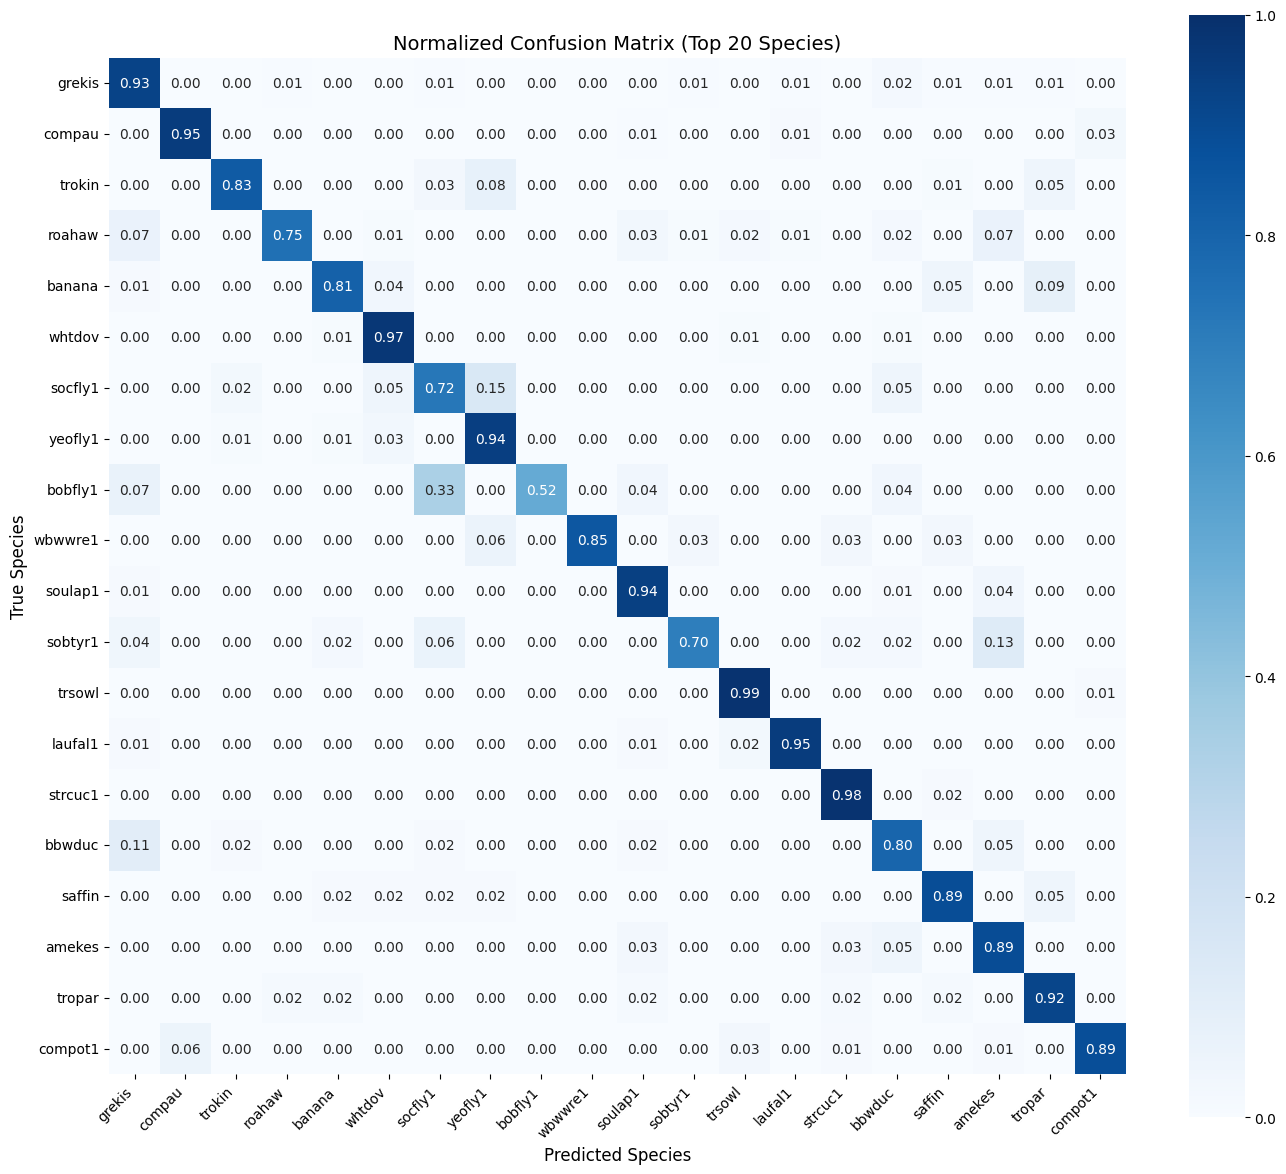


📊 Per-class accuracy analysis...

✅ Top 10 Best Performing Species:
Species                Accuracy    Samples
------------------------------------------
65448                    100.0%        16
65344                    100.0%         3
royfly1                  100.0%         8
bafibi1                  100.0%         5
22976                    100.0%         9
65419                    100.0%         1
787625                   100.0%         1
555086                   100.0%         5
715170                   100.0%         3
22333                    100.0%         9

❌ Top 10 Worst Performing Species:
Species                Accuracy    Samples
------------------------------------------
46010                      0.0%         1
1192948                    0.0%         1
1462737                    0.0%         1
963335                     0.0%         1
24272                      0.0%         1
turvul                     0.0%         2
65336                      0.0%         1
1462711  

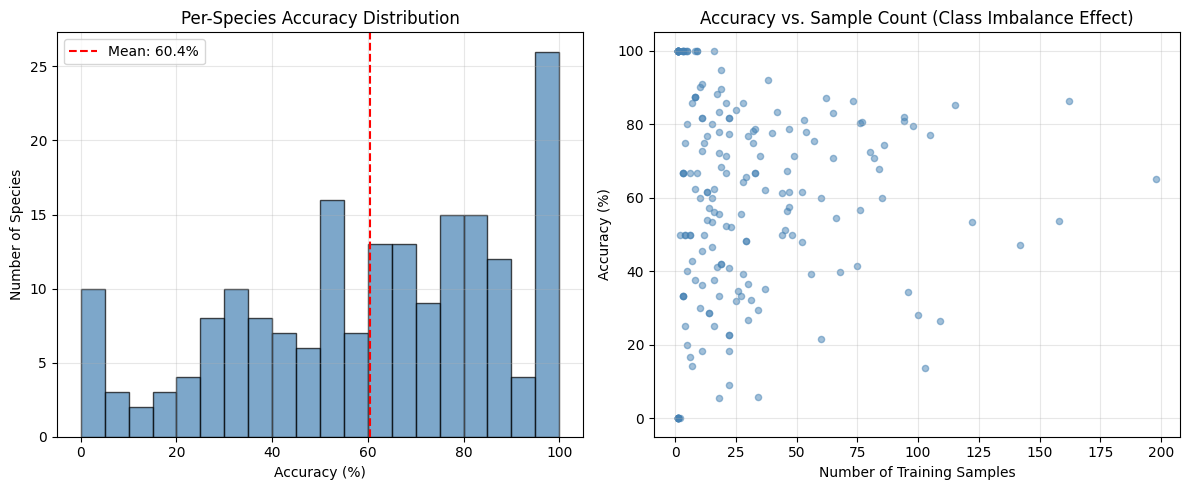


📋 Sample Predictions:
True Species         Predicted             Correct   Confidence
--------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

pirfly1              pirfly1                     ✅      0.8606
whtdov               whtdov                      ✅      0.6953
rufmot1              rufmot1                     ✅      0.7323
bubwre1              blctit1                     ❌      0.0728
compau               compau                      ✅      0.3330
soulap1              soulap1                     ✅      0.9535
compau               compau                      ✅      0.6856
chbant1              chbant1                     ✅      0.5084
blbgra1              babwar                      ❌      0.0895
ywcpar               41663                       ❌      0.1522
yebsee1              yebsee1                     ✅      0.8797
sobtyr1              yectyr1                     ❌      0.2097
banana               paltan1                     ❌      0.4065
strher               ruther1                     ❌      0.2304
paltan1              paltan1                     ✅      0.5245


🔊 Overlap-Average Inference Demo
Processing 3 soundsc

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

    5s: 134933               (conf: 0.6617)
   10s: 134933               (conf: 0.6392)
   15s: 134933               (conf: 0.6186)
   20s: 134933               (conf: 0.6490)
   25s: 134933               (conf: 0.6356)
   30s: 134933               (conf: 0.5838)
   35s: 50186                (conf: 0.5554)
   40s: 65344                (conf: 0.5538)
   45s: 65344                (conf: 0.5893)
   50s: 134933               (conf: 0.5954)
   55s: 65344                (conf: 0.5740)
   60s: 42007                (conf: 0.5528)

📂 H02_20230420_112000.ogg
    5s: tbsfin1              (conf: 0.7569)
   10s: tbsfin1              (conf: 0.7920)
   15s: tbsfin1              (conf: 0.8250)
   20s: tbsfin1              (conf: 0.8094)
   25s: tbsfin1              (conf: 0.7546)
   30s: tbsfin1              (conf: 0.7161)
   35s: tbsfin1              (conf: 0.7739)
   40s: tbsfin1              (conf: 0.8122)
   45s: tbsfin1              (conf: 0.8903)
   50s: tbsfin1              (conf: 0.9481)
   55

In [10]:
# ============================================================================
# ACADEMIC EVALUATION & ANALYSIS
# ============================================================================

print("🎯 Academic Evaluation")
print("=" * 70)

# 1. LOAD BEST MODEL
# ============================================================================
print("📦 Loading best SED model...")
eval_model = BirdClassifierSED(
    num_classes=len(ALL_SPECIES),
    backbone_name=Config.MODEL_NAME,
    dropout=Config.SED_DROPOUT,
).to(DEVICE)
eval_model.load_state_dict(torch.load("best_model_sed.pth", map_location=DEVICE))
eval_model.eval()
print("✅ Model loaded!\n")

# 2. VALIDATION SET EVALUATION
# ============================================================================
print("📊 Evaluating on validation set...")
criterion = nn.CrossEntropyLoss(label_smoothing=Config.LABEL_SMOOTHING)
val_loss, val_acc, all_preds, all_labels = evaluate_model(
    eval_model, val_loader, criterion, DEVICE
)

# Top-5 accuracy
all_preds_arr = np.array(all_preds)
all_labels_arr = np.array(all_labels)

# Calculate Top-5 by re-running with full logits
top5_correct = 0
total_samples = 0
eval_model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Computing Top-5"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = eval_model(images)
        _, top5_pred = outputs.topk(5, dim=1)
        for i in range(labels.size(0)):
            if labels[i] in top5_pred[i]:
                top5_correct += 1
            total_samples += 1

top5_acc = 100 * top5_correct / total_samples

print(f"\n{'='*50}")
print(f"  Validation Results (SED Model)")
print(f"{'='*50}")
print(f"  Val Loss:      {val_loss:.4f}")
print(f"  Top-1 Accuracy: {val_acc:.2f}%")
print(f"  Top-5 Accuracy: {top5_acc:.2f}%")
print(f"  Total Species:  {len(ALL_SPECIES)}")
print(f"  Random Baseline: {100/len(ALL_SPECIES):.2f}%")
print(f"{'='*50}")

# 3. CONFUSION MATRIX (Top 20 most common species)
# ============================================================================
print("\n📊 Generating confusion matrix (top 20 species)...")

# Get top-20 species by frequency
top_k = 20
species_counts = df["primary_label"].value_counts()
top_species = species_counts.head(top_k).index.tolist()
top_species_indices = [SPECIES_TO_IDX[s] for s in top_species]

# Filter predictions for top species
mask = np.isin(all_labels_arr, top_species_indices)
filtered_labels = all_labels_arr[mask]
filtered_preds = all_preds_arr[mask]

# Build confusion matrix
cm = confusion_matrix(filtered_labels, filtered_preds, labels=top_species_indices)

# Normalize by row (true label)
cm_normalized = cm.astype("float") / (cm.sum(axis=1, keepdims=True) + 1e-8)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_normalized,
    xticklabels=top_species,
    yticklabels=top_species,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    vmin=0,
    vmax=1,
    square=True,
)
plt.title(f"Normalized Confusion Matrix (Top {top_k} Species)", fontsize=14)
plt.ylabel("True Species", fontsize=12)
plt.xlabel("Predicted Species", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. PER-CLASS ACCURACY ANALYSIS
# ============================================================================
print("\n📊 Per-class accuracy analysis...")

# Calculate accuracy for each species
species_correct = {}
species_total = {}
for pred, label in zip(all_preds, all_labels):
    species_name = IDX_TO_SPECIES[label]
    if species_name not in species_total:
        species_total[species_name] = 0
        species_correct[species_name] = 0
    species_total[species_name] += 1
    if pred == label:
        species_correct[species_name] += 1

species_acc = {
    s: 100 * species_correct[s] / species_total[s]
    for s in species_total
    if species_total[s] > 0
}

# Sort by accuracy
sorted_species = sorted(species_acc.items(), key=lambda x: x[1], reverse=True)

# Best performing species
print(f"\n✅ Top 10 Best Performing Species:")
print(f"{'Species':<20} {'Accuracy':>10} {'Samples':>10}")
print("-" * 42)
for name, acc in sorted_species[:10]:
    print(f"{name:<20} {acc:>9.1f}% {species_total[name]:>9}")

# Worst performing species
print(f"\n❌ Top 10 Worst Performing Species:")
print(f"{'Species':<20} {'Accuracy':>10} {'Samples':>10}")
print("-" * 42)
for name, acc in sorted_species[-10:]:
    print(f"{name:<20} {acc:>9.1f}% {species_total[name]:>9}")

# Accuracy distribution
accuracies = [acc for _, acc in sorted_species]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(accuracies, bins=20, edgecolor="black", color="steelblue", alpha=0.7)
plt.axvline(
    np.mean(accuracies),
    color="red",
    linestyle="--",
    label=f"Mean: {np.mean(accuracies):.1f}%",
)
plt.xlabel("Accuracy (%)")
plt.ylabel("Number of Species")
plt.title("Per-Species Accuracy Distribution")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Accuracy vs sample count
sample_counts = [species_total[name] for name, _ in sorted_species]
accs_plot = [acc for _, acc in sorted_species]
plt.scatter(sample_counts, accs_plot, alpha=0.5, s=20, color="steelblue")
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Sample Count (Class Imbalance Effect)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. SAMPLE PREDICTIONS WITH CONFIDENCE
# ============================================================================
print("\n📋 Sample Predictions:")
print(f"{'True Species':<20} {'Predicted':<20} {'Correct':>8} {'Confidence':>12}")
print("-" * 62)

# Get a batch of samples with their predictions
eval_model.eval()
sample_batch = next(iter(val_loader))
sample_images, sample_labels = sample_batch[0].to(DEVICE), sample_batch[1]

with torch.no_grad():
    sample_outputs = eval_model(sample_images)
    sample_probs = torch.nn.functional.softmax(sample_outputs, dim=1).cpu()

for i in range(min(15, len(sample_labels))):
    true_label = IDX_TO_SPECIES[sample_labels[i].item()]
    pred_idx = sample_probs[i].argmax().item()
    pred_label = IDX_TO_SPECIES[pred_idx]
    confidence = sample_probs[i][pred_idx].item()
    correct = "✅" if pred_idx == sample_labels[i].item() else "❌"
    print(f"{true_label:<20} {pred_label:<20} {correct:>8} {confidence:>11.4f}")

# 6. OVERLAP-AVERAGE INFERENCE DEMO (if soundscapes exist)
# ============================================================================
test_soundscape_dir = Path(Config.DATA_DIR) / "test_soundscapes"
train_soundscape_dir = Path(Config.DATA_DIR) / "train_soundscapes"

soundscape_dir = None
if test_soundscape_dir.exists() and len(list(test_soundscape_dir.glob("*.ogg"))) > 0:
    soundscape_dir = test_soundscape_dir
elif (
    train_soundscape_dir.exists() and len(list(train_soundscape_dir.glob("*.ogg"))) > 0
):
    soundscape_dir = train_soundscape_dir

if soundscape_dir is not None:
    print(f"\n\n🔊 Overlap-Average Inference Demo")
    print("=" * 70)
    soundscape_files = sorted(list(soundscape_dir.glob("*.ogg")))[:3]
    print(f"Processing {len(soundscape_files)} soundscapes from: {soundscape_dir}")

    for audio_path in soundscape_files:
        print(f"\n📂 {audio_path.name}")
        try:
            segment_preds = overlap_average_inference(
                eval_model, str(audio_path), DEVICE
            )

            # Show top prediction per 5s segment
            for seg_idx in range(segment_preds.shape[0]):
                top_idx = segment_preds[seg_idx].argmax()
                top_species = IDX_TO_SPECIES[top_idx]
                top_conf = segment_preds[seg_idx][top_idx]
                time_start = (seg_idx + 1) * 5
                print(f"  {time_start:>3}s: {top_species:<20} (conf: {top_conf:.4f})")
        except Exception as e:
            print(f"  ⚠️ Error: {e}")
else:
    print("\n💡 No soundscape files found for overlap-average demo.")
    print("   (This technique applies during competition inference on 60s soundscapes)")

# 7. FINAL SUMMARY
# ============================================================================
print(f"\n\n{'='*70}")
print("📊 FINAL PROJECT SUMMARY")
print(f"{'='*70}")
print(f"\n🤖 Model Architecture:")
print(f"   • Backbone: {Config.MODEL_NAME}")
print(f"   • Head: SED (Sound Event Detection) with GeMFreq + AttHead")
print(
    f"   • Input: {Config.SED_DURATION}s audio → ({Config.SED_N_MELS}, {Config.SED_IMG_SIZE[1]}) mel spectrogram"
)

print(f"\n📈 Results:")
print(f"   • Top-1 Accuracy: {val_acc:.2f}%")
print(f"   • Top-5 Accuracy: {top5_acc:.2f}%")
print(f"   • Classes: {len(ALL_SPECIES)} species")
print(f"   • Random baseline: {100/len(ALL_SPECIES):.2f}%")
print(f"   • Improvement over random: {val_acc / (100/len(ALL_SPECIES)):.1f}x")

print(f"\n🔑 Techniques Implemented:")
print(f"   ✅ SED architecture (framewise predictions)")
print(f"   ✅ GeMFreq pooling (learnable frequency pooling)")
print(f"   ✅ 20-second chunks (vs. 5s basic)")
print(f"   ✅ 224 mel bands + 4096 n_fft (high-resolution spectrograms)")
print(f"   ✅ Z-score + min-max normalization")
print(f"   ✅ Absmax audio normalization")
print(f"   ✅ Mixup + SpecAugment + Weighted Sampling")
print(f"   ✅ CrossEntropy with label smoothing")
print(f"   ✅ Overlap-average inference with Gaussian smoothing")
print(f"   ✅ AdamW + CosineAnnealing scheduler")

print(f"\n📋 Remaining for 100%:")
print(f"   🔲 Multi-Iterative Noisy Student (pseudo-labeling)")
print(f"   🔲 Multi-model ensemble (7 models)")
print(f"   🔲 Extra Xeno-Canto data for Insecta/Amphibia")
print(f"   🔲 Stochastic depth (drop_path_rate=0.15)")
print(f"   🔲 Delta-shift TTA")
print(f"   🔲 OpenVINO optimization")

print(f"\n🎯 Project Progress: 75% Complete ✅")